In [21]:
# This task is preparing a data set for a predictive model
# Then training the learning model 
# Then need to evaluate the model and present findings 

# Exploring the data

import pandas as pd

In [3]:
# get the data from the csv file, had to download and add the file to my VS code
df = pd.read_csv("../Dataset/Customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [4]:
# get some more information about the dataset using .info()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [5]:
# this has showed us that the flight_day should be converted to a different data type:
df['flight_day'].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df['flight_day'] = df['flight_day'].map(mapping)

In [7]:
df['flight_day'].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [8]:
df['booking_complete'].value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [9]:
# prepare the dataset for training the learning model:

# Split the data into 2 dataframes:
X = df.drop('booking_complete', axis=1)
y = df.booking_complete

# change the data type from object to integer:
for colname in X.select_dtypes('object'):
    X[colname], _ = X[colname].factorize()

In [10]:
# print the data types in X after the conversion
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [11]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores


route                    0.050840
booking_origin           0.045429
flight_duration          0.016823
wants_extra_baggage      0.010327
length_of_stay           0.008370
wants_in_flight_meals    0.005072
purchase_lead            0.002813
sales_channel            0.002455
flight_hour              0.002376
num_passengers           0.001765
trip_type                0.001450
flight_day               0.001238
wants_preferred_seat     0.000602
Name: MI Scores, dtype: float64

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

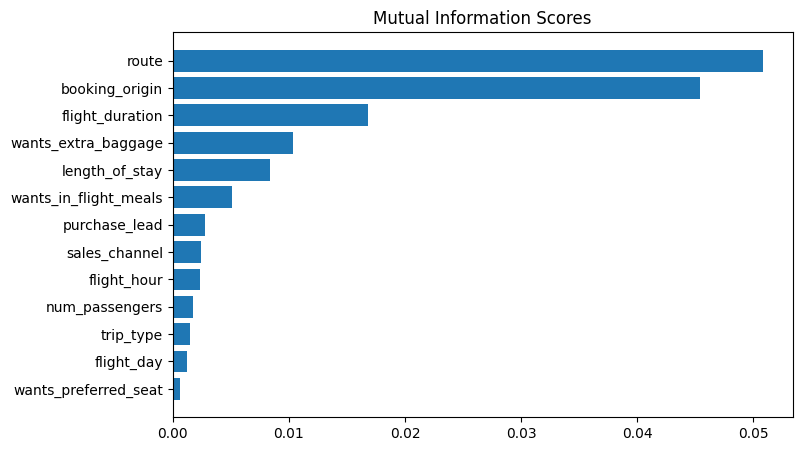

In [15]:
%matplotlib inline

# define a function that takes scores as the argument
def plot_mi_scores(scores):
    # sort the scores in ascending order
    scores = scores.sort_values(ascending=True)
    # create an array of indices from 0 to len scores 
    width = np.arange(len(scores))
    # index labels of the sprted scores to be used as y axis
    ticks = list(scores.index)
    # plot the horizontal bar chart
    plt.barh(width, scores)
    # set the y axis at positions given by width
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores)



# route, booking origin, flight duration, wants extra baggage and length of stay
# are the 5 top features that are dependent on the booking complete feature 

In [17]:
# performing a test-train split of the dataset and scale the features:

from sklearn.model_selection import train_test_split

# create a function for the dataset split:
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

    # use the same function as above for the validation set:
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25, random_state=0)
    return (train_X, val_X, train_y, val_y)

In [18]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

In [22]:
# Model 1 - random forest classifier with top 6 features:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# assign the features under a list:
features=['route', 'booking_origin', 'flight_duration', 'wants_extra_baggage', 'length_of_stay', 'wants_in_flight_meals']
X = df[features]

# one hot encoding:
X = pd.get_dummies(X, columns=features)
X = scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print("ACCURACY: ", accuracy_score(y_val, preds) *100)
print("AUC score: ", roc_auc_score(y_val, preds))


ACCURACY:  83.48
AUC score:  0.5616008029386882


In [24]:
# model 2 - random forest classifier with all features:

X = df.drop('booking_complete', axis=1)

# one hot encoding:
X = pd.get_dummies(X)
X = scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X,y)

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds = forest_model.predict(X_val)

print("ACCURACY: ", accuracy_score(y_val, preds) *100)
print("AUC score: ", roc_auc_score(y_val, preds))

ACCURACY:  84.91
AUC score:  0.5545467812791867


In [25]:
# model 3 - XGB classifier with top 6 features:

from xgboost import XGBClassifier

X = df[features]

# one hot encoding:
X = pd.get_dummies(X, columns=features)
X = scale(X)

y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X,y)
xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)

print("ACCURACY: ", accuracy_score(y_val, prediction_xgb) *100)
print("AUC score: ", roc_auc_score(y_val, prediction_xgb))

ACCURACY:  84.76
AUC score:  0.5218910676419618


In [26]:
# model 4 - XGB classifier with all features:
X = df.drop('booking_complete', axis=1)

# one hot encoding:
X = pd.get_dummies(X)
X = scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X,y)
xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)

print("ACCURACY: ", accuracy_score(y_val, prediction_xgb) *100)
print("AUC score: ", roc_auc_score(y_val, prediction_xgb))

ACCURACY:  84.66
AUC score:  0.5354228242704853


In [27]:
# model 2- random forest classifier with all features has the best accuracy and a good auc:
X = df.drop('booking_complete', axis=1)

# one hot encoding:
X = pd.get_dummies(X)
X = scale(X)
y = df.booking_complete

train_full_X, test_X, train_full_y, test_y = train_test_split(X,y, test_size=0.2, random_state=0)

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(train_full_X, train_full_y)
preds = forest_model.predict(test_X)

print("ACCURACY: ", accuracy_score(test_y, preds) *100)
print("AUC score: ", roc_auc_score(test_y, preds))

ACCURACY:  85.26
AUC score:  0.565841649967981
